# Simulate gamma ray sources in galaxy

## Imports and definitions

In [3]:
#Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson, laplace, lognorm
from astropy.io import fits
from astropy.table import Table,join
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import catalog_spect
from scipy.optimize import curve_fit
import astropy.coordinates as coord
from astropy import units
from matplotlib import gridspec
from matplotlib import rc
import matplotlib.ticker
import makemap
rc('font',**{'family':'serif'})
rc('text',usetex=True)

##colors
c6 = '#e41a1c'
c2 = '#377eb8'
c3 = '#4daf4a'
c4 = '#984ea3'
c5 = '#ff7f00'
c1 = '#66c2a5'
c7 = '#a65628'
c8 = '#f781bf'
c9 = '#999999'
colors = [c1,c2,c3,c4,c5,c6,c7,c8,c9]

%matplotlib inline
#constants 
kpc = 3.08567758e21 #cm
##SNR distribution From Green 2015
alp_snr = 1.09
bet_snr = 3.98
H_snr = 0.083 #jian-wen xu et al 2004
Rsun = 8.3

##This is for pulsars
model = 'C' #Set model to S or C
if model=='C':
    H=0.18
    alp=1.9
    bet = 5.0
if model=='S':
    H=0.33
    alp=0.2
    bet = 1.4
if model=='SNR':
    H = 0.083
    alp = alp_snr
    bet = bet_snr
    
#Trheshold of fermi, from 3fgl paper
fermi_thres = 5e-10

##Setting up some things for later
minflux,maxflux=-14,-5
bins = np.logspace(minflux,maxflux,25)
bins_mean = (bins[1:]+bins[:-1])/2.

#lb regions
lb = [(180,20),(180,5),(180,1),(20,20),(20,5),(20,1)]

##Set up bins for energy for fhl (10-1000GeV) and fgl (0.1-100GeV)
Efhl = np.logspace(1,3,100)#GeV
E3fgl_bins = np.logspace(-1,2,101)
E3fgl = (E3fgl_bins[1:]+E3fgl_bins[0:-1])/2.
E3fgl_dE = (E3fgl_bins[1:]-E3fgl_bins[0:-1])
mask_E3fgl = (E3fgl>=1)&(E3fgl<=100)
#bins in energy for our use (1-1000GeV)
Ebins = np.logspace(0,3,101)
E = (Ebins[1:]+Ebins[0:-1])/2.
dE = (Ebins[1:]-Ebins[0:-1])
mask_E3fhl = E>100
mask_E = (E>=1)&(E<=100)


## Function definitions

In [4]:
#Function definitions
from scipy.stats import expon
##Drawing random numbers
def rand_R(n,a,b,Rsun=Rsun):
    "Return random value of R, pdf is above, this is a gamma distribution"
    return np.random.gamma(a+1,1./b,n)*Rsun

def rand_R_norm(n,mu,sig):
    "return normal random"
    return np.random.normal(mu,sig,n)

def rand_R_SNI(n,a,Rsun=Rsun):
    return np.random.exponential(a,n)

def R_SNR_ferriere(R):
    sig1 = 4.8*np.exp(-(R-Rsun)/4.5)
    sig2 = 27*np.where(R < 3.7,3.55*np.exp(-((R-3.7)/2.1)**2),
                   np.exp(-(R**2-Rsun**2)/6.8**2))
    return sig1+sig2

###CDFs for R ferriere only
rspace = np.linspace(0,30,1000)
data_r = R_SNR_ferriere(rspace)
data_r = data_r/np.sum(data_r) #normalize
data_r_cdf = np.cumsum(data_r)#cdf

def ITS(N,x,cdf):
    """Function to do inverse transform sampling 
    
    Input:
    N: int, number of desired random samples
    x: array, possible returned random samples
    cdf: cdf function
    
    """
    smpl = np.zeros(N)
    u = np.random.rand(N)
    for i in range(N):
        #Inverse transform sampling, numerical
        ix= np.argmax(u[i]<=cdf)
        smpl[i]=x[ix]
    return smpl

def rand_z(n,H=H):
    """Return random z from laplace distribution=exp(-abs(z))
    n = number of randoms"""
    return np.random.laplace(0,H,n)

def z_SNR_ferriere(z):
    "z in pc"
    R1 = 7.3*np.exp(-np.abs(z)/325.)
    R2 = 50 * (0.79*np.exp(-(z/212.)**2)+0.21*np.exp(-(z/636.)**2))
    return R1+R2

###CDFs for z ferriere only
zspace = np.linspace(-3000,3000,1000)
data_z = z_SNR_ferriere(zspace)
data_z = data_z/np.sum(data_z) #normalize
data_z_cdf = np.cumsum(data_z)#cdf

def rand_z_SNR_ferriere(N):
    z_smpl = np.zeros(N)

    u = np.random.rand(N)
    for i in range(N):
        #Inverse transform sampling, numerical
        xx= np.argmax(u[i]<=data_z_cdf)
        z_smpl[i]=z[xx]
    return z_smpl/1000. #kpc

def rand_L(u,a,Lmin,Lmax):
    """Random L generator. Uses inverse transform sampling.
        u is a uniform random number between 0-1, a is the index of the
        power law distributiond desired.
        L = CDF^-1(u)
    """
    if a==1:
        print "a==1, error" #does not work for this..
        return 0
    return (u*(Lmax**(1-a)-Lmin**(1-a))+Lmin**(1-a))**(1/(1-a))


def norm_spec(spec,flux,dE,mask):
    """This function normalizes the spec(actually wrong_spec below) 
    to the integrated flux from 1-100GeV
    """
    wrong_spec = spec*flux
    norm = np.sum(wrong_spec[mask]*dE[mask])
    return wrong_spec*flux/norm

def read_catalog(fn,catalog='fgl',classes=['pwn','snr','spp']):
    """
    Reads the catalog, either 3FGL or 3FHL, and returns the average 
    spectrum of the desired sources.
    
    Still have to adjust so that it returns the right spectrum...
    
    Returns also the histogram counts vs flux
    """
    data = fits.getdata(fn)
    tb = Table(data)
    if catalog=='fgl':
        _E = E3fgl
        cls = np.asarray(tb['CLASS1'].tolist())
    else:
        _E = Efhl
        cls = np.asarray(tb['CLASS'].tolist())
    cls = np.char.lower(np.char.rstrip(cls,' '))
    mask = np.zeros_like(cls,dtype=bool)

    for m in classes:
        mask = (cls==m)|mask
    
    if catalog == 'fgl':
        flux = tb[mask]['Flux1000']
    if catalog == 'fhl':
        flux = tb[mask]['Flux']

    spec = catalog_spect.get_spec(fn) ###This function returns the spectra of the catalogue    
    spec = spec[mask]
    
    ave_spec = 10**np.average(np.log10(spec),axis=0)
    
    hist_3fgl = np.histogram(flux,bins=bins)[0]
    total_flux = np.sum(flux)

    if catalog=='fgl':
        ind = np.mean(tb[mask]['Spectral_Index'])
    if catalog=='fhl':
        ind = np.mean(tb[mask]['PowerLaw_Index'])

    return hist_3fgl,ave_spec,spec#spec_normed,ind


def lnlike(model,y):
    "Poisson likelihood, -2lnL"
    k = model
    lmbda = y
    tot = k-lmbda+k*np.log((lmbda+1e-60)/(k+1e-60))
    return -2.*np.sum(tot)
    

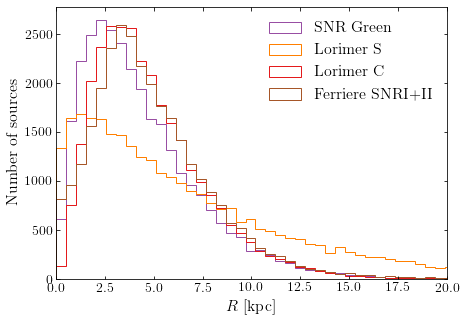

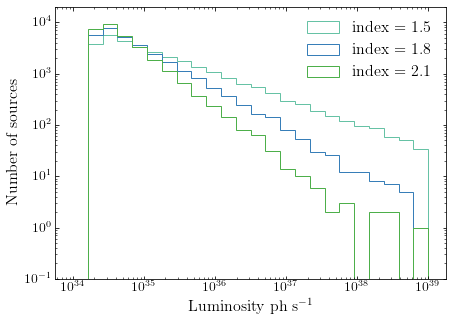

In [5]:
atest=[(1.09,3.98),(0.2,1.4),(1.9,5.0)]
labels = ['SNR Green','Lorimer S','Lorimer C', 'Ferriere SNRI+II']

f,ax = plt.subplots(1,figsize=(7,5))
for i,a in enumerate(atest):
    ax.hist(rand_R(30000,a[0],a[1]),bins=np.linspace(0,25),label=labels[i],histtype='step',color=colors[i+3])

    
ax.hist(ITS(30000,rspace,data_r_cdf),bins=np.linspace(0,25),label=labels[3],histtype='step',color=colors[i+4])
ax.set_xlim([0,20])
ax.set_xlabel(r'$R \ \mathrm{[kpc]}$',fontsize=16)
ax.set_ylabel(r'Number of sources',fontsize=16)
ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
plt.legend(frameon=False,fontsize=16)
#plt.savefig('R_hist.pdf')
Ltest = [1.5,1.8,2.1]
f,ax = plt.subplots(1,figsize=(7,5))
for i,l in enumerate(Ltest):
    ax.hist(rand_L(np.random.rand(30000),l,2e34,2e39),bins=np.logspace(34,39,25), color=colors[i],
           label='index = %s'%l,histtype='step',log=True)
    ax.set_xscale('log',nonposx='clip')
    ax.set_xlabel(r'Luminosity $\rm{ph \ s^{-1}}$',fontsize=16)
    ax.set_ylabel(r'Number of sources',fontsize=16)
    ax.set_ylim([0.1,2e4])
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
plt.legend(frameon=False,fontsize=16)
# plt.savefig('lum_hist.pdf')
# plt.close('all')

## Read CTA DC data

In [6]:
import readXML

CTA_file = 'catalog_gps_20180124.xml'
CTA_file_lowTS = 'catalog_gps_20180124_lowTS.xml'

flux_CTA,spec_CTA,E_CTA = readXML.flux_spec(CTA_file) ##Flux from 300-1000 GeV ph s^-1 cm^-2

In [7]:
bins = np.logspace(-17,-10,30)
bins_mean = (bins[1:]+bins[:-1])/2.
hist_CTA = np.histogram(flux_CTA,bins=bins)[0]

spec_ave_CTA = np.average(spec_CTA,axis=0)

Ebins = np.logspace(2,5,51)
E = (Ebins[1:]+Ebins[0:-1])/2.
dE = (Ebins[1:]-Ebins[0:-1])
mask_E = (E>=300)&(E<=1000)
spec_ave_CTA = 1e-9*E**-2.2

## Load diffuse data

In [8]:
###Load diffuse flux from skyfact fit
###Here load the diffuse flux at different l,b. To plot some fractions later.

import open_dat
from scipy import optimize

def errfunc(theta,f,x,y,yerr):
    """leastsq function"""
    if isinstance(yerr,int):
        yerr = yerr
    else:
        yerr = yerr/(np.log10(10)*y)
    x = np.log10(x)
    y = np.log10(y)
    model = f(x,theta)
    return np.sum(((y-model)/yerr)**2)

fitf = lambda *args: errfunc(*args)
modelfunc = lambda x,p: p[0]-p[1]*x
model27 = lambda x,p: p[0]-2.7*x

p0 = [-7,2.7]

def fit_index(E,flux,error=1,model=modelfunc,p0=p0):
    #fit,cov = curve_fit(model,np.log10(E),np.log10(flux),sigma=error/(np.log10(10)*flux),p0=p0)
    res = optimize.minimize(fitf,p0,args=(model,E,
                                            flux,error))
    return res["x"],res["hess_inv"]
    #return fit,cov

def read_datfile(datFile):
    "Read dat file and return total gas spec (sum)"
    E_diff = datFile['emean']
    deltaE = datFile['delta_e']
    total_gas_spec = np.zeros_like(E_diff)
    total_gas_err = np.zeros_like(E_diff)
    mask_diff = E_diff > 1
    for d in datFile:
        if 'Gas' in d and not 'err' in d:
            total_gas_spec+=datFile[d]
            total_gas_err +=datFile[d+'_err']
    return total_gas_spec/deltaE,E_diff,total_gas_err/deltaE
    
spec_diff_lb = []
diff_index_lb = []
spec_27_l = []
spec_dat = []
plotfunc = lambda E,a,b: b*(E)**-a
fitfunc = lambda E,a,b: b-a*(E)

for ilb in lb:
    datfile = open_dat.open_dat('/home/mart/mp/git_mp/spec_ll_bb/r5_fulldisk_combine_l%s_b%s.dat'%ilb)
    spec,E_diff,error = read_datfile(datfile)
    spec_dat.append(spec)
    mask_E_diff = E_diff > 2
    E_diff2 = E_diff
    E_diff = E_diff[mask_E_diff]
    spec = spec[mask_E_diff]
    err = error[mask_E_diff]
    
    fit,cov = fit_index(E_diff,spec,err,model=modelfunc,p0=[-7,2.7])
    fit27,cov27 = fit_index(E_diff,spec,err,model=model27,p0=[-7])

    ####
    ####This matters a lot!
    diff_index = fit[1]

    fitted_spec = plotfunc(E,diff_index,10**fit[0]) ##If this is a softer spectra this matters a lot!

    spec_diff_lb.append(fitted_spec)

## Simulate sources

In [9]:
##This is the galaxy simulation
#Do the simulation of sources

def source_sim(a=1.8,N=30000,Lmin=2e34,Lmax=2e39,alpha=alp,beta=bet,H=H,
               f_t=fermi_thres,spectrum=spec_ave_CTA,createmap=False):
    #np.random.seed(0)
    """Sample from above distribution N times: r,z,L and calculate flux as measured at earth.
    Returns histogram of sources, total flux from sources and average spec from sources and
    fraction of unresolved/diffuse.
    """
    
    N = int(N) #no samples just to be sure 
    x0,y0,z0 = Rsun,0,0 #Location of us
    ##
    ##Drawing random numbers here
    u2 = np.random.rand(N)# For L
    phi_smpl = np.random.rand(N)*2*np.pi #uniform distribution for phi
    L_smpl = rand_L(u2,a,Lmin,Lmax)#random L
    
    if model=='ferriere':
        R_smpl = ITS(N,rspace,data_r_cdf)
        z_smpl = ITS(N,zspace,data_z_cdf)/1000. #kpc
    else:
        z_smpl = rand_z(N,H)
        R_smpl = rand_R(N,alpha,beta)

    #distances from source to earth, calc flux
    x,y,z = R_smpl*np.cos(phi_smpl),R_smpl*np.sin(phi_smpl),z_smpl
    dist = np.sqrt(((x-x0))**2+((y-y0))**2+(z-z0)**2)
    distkpc = (dist*kpc)
    flux_data = L_smpl/(4*np.pi*distkpc**2)
    ##Calculate longitude and latitude
    l = np.arctan2((y0-y),(x0-x))
    b = np.arctan((z-z0)/np.sqrt((x-x0)**2+(y-y0)**2))
    l *= 180/np.pi
    b *= 180/np.pi
        
    #histogram for normalization
    hist = np.histogram(flux_data,bins=bins)[0]
    mask_flux = flux_data < f_t
    meandist = np.mean(dist[flux_data > 5e-9])
    maskb = np.abs(b) <= 20.25
    fluxb = flux_data[maskb]
    total_flux = np.sum(fluxb[fluxb <f_t])
    
    if createmap:
        mp = makemap.makemap(l[mask_flux],b[mask_flux],flux_data[mask_flux],0.5)
    else:
        mp = 0
       
    #Fluxes at different regions,lb
    spec_unres = []
    frac = []
    frac_tev = []
    for ilb,_lb in enumerate(lb):
        ll,bb = _lb
        mask_l = np.abs(l)<=ll
        mask_b = np.abs(b)<=bb
        total_flux_lb = flux_data[mask_l&mask_b]
        flux_unresolved = total_flux_lb[total_flux_lb<f_t]
        total_flux_unres = np.sum(flux_unresolved)
        spec_sim = norm_spec(spectrum,total_flux_unres,dE,mask_E)
        diffuse = spec_diff_lb[ilb]
        frac_TeV = total_flux_unres/np.sum((spec_diff_lb[ilb]*dE)[mask_E])
        frac_tev.append(frac_TeV)
        frac.append(spec_sim/diffuse)
        spec_unres.append(spec_sim)

    return hist,frac,mp,total_flux,frac_tev,flux_data#,flux_R_unres#,mp

In [44]:
#Runs simulation Nsmpl times with N=n.o. sources, normalize to 3fgl sources
##Get average and std from Nsmpl runs, plot histogram to compare with hist of 3fgl sources

def ave_samples(Nsmpl=10,Nsnr=10000,LF_i_snr=1.5,Lmin_snr=1e33,Lmax_snr=4e38,
                ft=fermi_thres,alpha=alp_snr,beta=bet_snr,H=H_snr,
                spectrum=spec_CTA,cm=False,printstatements=True):

    if printstatements:
        print """Doing %s sample galaxys with %s sources,LF_i = %s, Lmin = %s,Lmax=%s, 
        this might take some time..."""%(Nsmpl,Nsnr,LF_i_snr, Lmin_snr, Lmax_snr)
    fluxes = []
    hists = np.zeros((Nsmpl,len(bins_mean)))
    fracs = []
    specs = []
    unres_flux = []
    l_map = []
    frac_tev = []
    flux_all_list = []
    
    for i in range(Nsmpl):
        hists[i,:],frac_lb,mapje,tf,ftv,flux_all = source_sim(LF_i_snr,Nsnr,Lmin_snr,Lmax_snr,
                                                             alpha,beta,H,f_t=ft,
                                                             spectrum=spectrum,createmap=cm)
     
        fracs.append(frac_lb)
        unres_flux.append(tf)
        l_map.append(mapje)
        frac_tev.append(ftv)
        flux_all_list.append(flux_all)

    ave_hist = np.rint(np.mean(hists,axis=0))
    std_hist = (np.std(hists,axis=0))
    ave_frac_lb = np.mean(fracs,axis=0)
    std_frac_lb = np.std(fracs,axis=0)
    mask_complete = (bins_mean >= ft)
    ave_map = np.mean(l_map,axis=0)
    ave_frac_tev = np.mean(frac_tev,axis=0)
    std_frac_tev = np.std(frac_tev,axis=0)
    ave_flux_all = np.mean(flux_all_list,axis=0)
    mean_unres_flux = np.mean(unres_flux)
    if printstatements:
        print "...done"
    return ave_frac_lb,std_frac_lb,ave_map,ave_frac_tev,std_frac_tev,ave_hist,std_hist

In [45]:
def plot_hist_func(bins,hist,std_hist,hist_norm,options,ft):

    mask_complete = (bins >= ft)
    counts_snr = np.sum(hist[mask_complete])
    Nsnr,LF_i_snr,Lmin_snr,Lmax_snr = options
    f1,ax1 = plt.subplots(1,figsize=(10,8))  
    ax1.loglog(bins,hist,marker='^',label='Simulated sources (N=%s)'%Nsnr, color=c3)

    ax1.tick_params(axis='both',direction='in',which='both',top='on',right='on',left='on',labelsize=14,labelbottom='on')
#         ax1.set_ylim([0.5,1e5])
    ax1.fill_between(bins,hist-std_hist,
                     hist+std_hist,where=((hist-std_hist)>0),facecolor=c3,alpha=0.2)
    ax1.fill_between(bins,0,hist+std_hist,where=(((hist-std_hist)<=0)&(hist>0)),
                     facecolor=c3,alpha=0.2)

    ##Plot 3fgl
    ax1.loglog(bins,hist_norm,marker='s',label='CTA DC galactic sources (n=%s)'%np.sum(hist_norm),color=c4)

    #ax1.set_title([Nsnr,LF_i_snr,Lmin_snr])
    ax1.set_xlabel(r'Flux from 3-1000 GeV [ph $\mathrm{cm^{-2} \ s^{-1}}]$',fontsize=16)
    ax1.set_ylabel('Number of sources',fontsize=16)
    
    ax1.set_title(r'$N= %s$, $\rm{index} = %s$, $L_{\rm{min}} = %s$, $L_{\rm max}=%s$, \\ %s at $>$ %s'%(Nsnr, LF_i_snr,Lmin_snr,
                                                                                                         Lmax_snr,
                                                                                    counts_snr,ft),fontsize=20)

    ax1.set_ylim([0.7,5e4])
#         ax2 = ax1.twinx()
#     ax1.loglog(bins_mean,np.cumsum(ave_hist_snr[::-1])[::-1],marker='^',color=c5,label=r'Simulation $N(>S)$')
#     ax1.loglog(bins_mean,np.cumsum(hist_CTA[::-1])[::-1],marker='s',color=c6,label=r'CTA DC $N(>S)$')

#         ax2.set_ylabel(r'$N(N>S)$',fontsize=16)

#         ax2.tick_params(axis='both',direction='in',which='both',top='on',right='on',left='on',labelsize=14,labelbottom='on')
    ax1.legend(prop={'size':18},frameon=False,handlelength=2.3)
#         ax2.legend(prop={'size':18},frameon=False,handlelength=2.3)
    save = False
    if save:
        plt.savefig('flux_counts_hist_ops_%s_%s_%s_C.pdf'%(Nsnr,LF_i_snr,Lmin_snr))

Doing 10 sample galaxys with 5000 sources,LF_i = 1.5, Lmin = 1e+31,Lmax=1e+35, 
        this might take some time...
...done


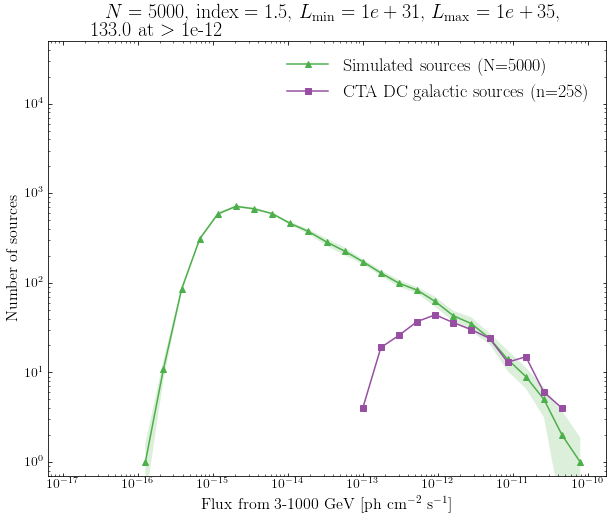

In [46]:
###Example run


lb_frac,std_lb_frac,mp,tev,std_tev,hist_flux,std_hist = ave_samples(10,Nsnr=5000,LF_i_snr=1.5,
                            Lmin_snr=1e31,Lmax_snr=1e35,
                           alpha=alp,beta=bet,H=H,
                           ft=1e-12,spectrum=spec_ave_CTA,cm=True)

    
plot_hist_func(bins_mean,hist_flux,std_hist,hist_CTA,(5000,1.5,1e31,1e35),1e-12)
# hist = np.histogram(ave_flux,bins=bins)[0]
# plt.figure()
# plt.loglog(bins_mean,np.cumsum(hist[::-1])[::-1],marker='s')
# plt.loglog(bins_mean,np.cumsum(hist_CTA[::-1])[::-1],marker='o')

# mp[mp==0]=1e-16

# fig = plt.figure(figsize=(25,10))
# ax = fig.add_subplot(111)
# ax.set_xticks([0,180,360,540,720])
# ax.set_xticklabels([0,90,180,270,360])
# ax.set_yticks([0,90,180,270,360])
# ax.set_yticklabels([90,45, 0,-45,-90])
# ax.set_ylim([140,220])
# ax.set_xlabel('l')
# ax.set_ylabel('b')
# im = ax.imshow(np.log10(mp[:,:]),cmap='hot',vmin=-16,vmax=-9)
# fig.colorbar(im,orientation='horizontal',shrink=0.5);


Doing 10 sample galaxys with 3374.0 sources,LF_i = 1.3, Lmin = 1e+30,Lmax=1e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 114.0
-2lnL = 10.0748767664
Doing 10 sample galaxys with 2984.0 sources,LF_i = 1.3, Lmin = 1e+30,Lmax=1.77827941004e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 111.0
-2lnL = 8.27298468045
Doing 10 sample galaxys with 2722.0 sources,LF_i = 1.3, Lmin = 1e+30,Lmax=3.16227766017e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 116.0
-2lnL = 10.1034041712
Doing 10 sample galaxys with 2536.0 sources,LF_i = 1.3, Lmin = 1e+30,Lmax=5.6234132519e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 114.0
-2lnL = 21.9971483316
Doing 10 sample galaxys with 2399.0 sources,LF_i = 1.

...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 119.0
-2lnL = 6.8826392165
Doing 10 sample galaxys with 9014.0 sources,LF_i = 1.5, Lmin = 2.15443469003e+30,Lmax=3.16227766017e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 125.0
-2lnL = 8.24598726008
Doing 10 sample galaxys with 8622.0 sources,LF_i = 1.5, Lmin = 2.15443469003e+30,Lmax=5.6234132519e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 130.0
-2lnL = 11.4569024899
Doing 10 sample galaxys with 8351.0 sources,LF_i = 1.5, Lmin = 2.15443469003e+30,Lmax=1e+36, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 122.0
-2lnL = 17.6172688413
Doing 10 sample galaxys with 21957.0 sources,LF_i = 1.6, Lmin = 2.15443469003e+30,Lmax=1e+35, 
    this might take some time...
...done
CTA no. s

...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 149.0
-2lnL = 20.0794841232
Doing 10 sample galaxys with 25707.0 sources,LF_i = 1.7, Lmin = 4.64158883361e+30,Lmax=1.77827941004e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 145.0
-2lnL = 16.3329136879
Doing 10 sample galaxys with 24694.0 sources,LF_i = 1.7, Lmin = 4.64158883361e+30,Lmax=3.16227766017e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 148.0
-2lnL = 11.0484148973
Doing 10 sample galaxys with 24060.0 sources,LF_i = 1.7, Lmin = 4.64158883361e+30,Lmax=5.6234132519e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 147.0
-2lnL = 13.128264066
Doing 10 sample galaxys with 23654.0 sources,LF_i = 1.7, Lmin = 4.64158883361e+30,Lmax=1e+36, 
    this might take some time...
..

...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 120.0
-2lnL = 8.1398520042
Doing 10 sample galaxys with 1695.0 sources,LF_i = 1.4, Lmin = 2.15443469003e+31,Lmax=3.16227766017e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 126.0
-2lnL = 8.44366912982
Doing 10 sample galaxys with 1606.0 sources,LF_i = 1.4, Lmin = 2.15443469003e+31,Lmax=5.6234132519e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 121.0
-2lnL = 18.0447641018
Doing 10 sample galaxys with 1543.0 sources,LF_i = 1.4, Lmin = 2.15443469003e+31,Lmax=1e+36, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 113.0
-2lnL = 20.0766208608
Doing 10 sample galaxys with 3287.0 sources,LF_i = 1.5, Lmin = 2.15443469003e+31,Lmax=1e+35, 
    this might take some time...
...done
CTA no. so

...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 140.0
-2lnL = 20.1814754622
Doing 10 sample galaxys with 5117.0 sources,LF_i = 1.7, Lmin = 4.64158883361e+31,Lmax=1.77827941004e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 146.0
-2lnL = 12.0770450474
Doing 10 sample galaxys with 4919.0 sources,LF_i = 1.7, Lmin = 4.64158883361e+31,Lmax=3.16227766017e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 144.0
-2lnL = 12.9353612374
Doing 10 sample galaxys with 4795.0 sources,LF_i = 1.7, Lmin = 4.64158883361e+31,Lmax=5.6234132519e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 136.0
-2lnL = 9.68620345102
Doing 10 sample galaxys with 4716.0 sources,LF_i = 1.7, Lmin = 4.64158883361e+31,Lmax=1e+36, 
    this might take some time...
...do

...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 115.0
-2lnL = 16.3424579676
Doing 10 sample galaxys with 929.0 sources,LF_i = 1.5, Lmin = 2.15443469003e+32,Lmax=1.77827941004e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 120.0
-2lnL = 6.38766051524
Doing 10 sample galaxys with 880.0 sources,LF_i = 1.5, Lmin = 2.15443469003e+32,Lmax=3.16227766017e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 122.0
-2lnL = 6.14222663711
Doing 10 sample galaxys with 847.0 sources,LF_i = 1.5, Lmin = 2.15443469003e+32,Lmax=5.6234132519e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 122.0
-2lnL = 11.009189448
Doing 10 sample galaxys with 824.0 sources,LF_i = 1.5, Lmin = 2.15443469003e+32,Lmax=1e+36, 
    this might take some time...
...done
CT

...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 114.0
-2lnL = 17.8916562496
Doing 10 sample galaxys with 268.0 sources,LF_i = 1.3, Lmin = 1e+33,Lmax=1e+36, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 114.0
-2lnL = 30.9797223053
Doing 10 sample galaxys with 379.0 sources,LF_i = 1.4, Lmin = 1e+33,Lmax=1e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 117.0
-2lnL = 9.48178353767
Doing 10 sample galaxys with 353.0 sources,LF_i = 1.4, Lmin = 1e+33,Lmax=1.77827941004e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 118.0
-2lnL = 10.872006548
Doing 10 sample galaxys with 336.0 sources,LF_i = 1.4, Lmin = 1e+33,Lmax=3.16227766017e+35, 
    this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources a

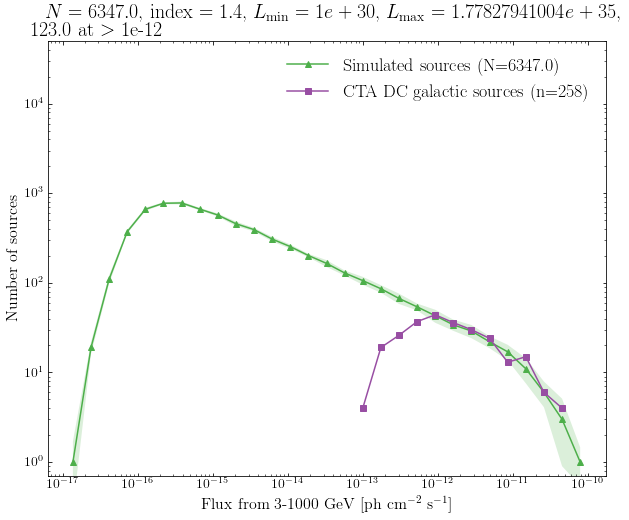

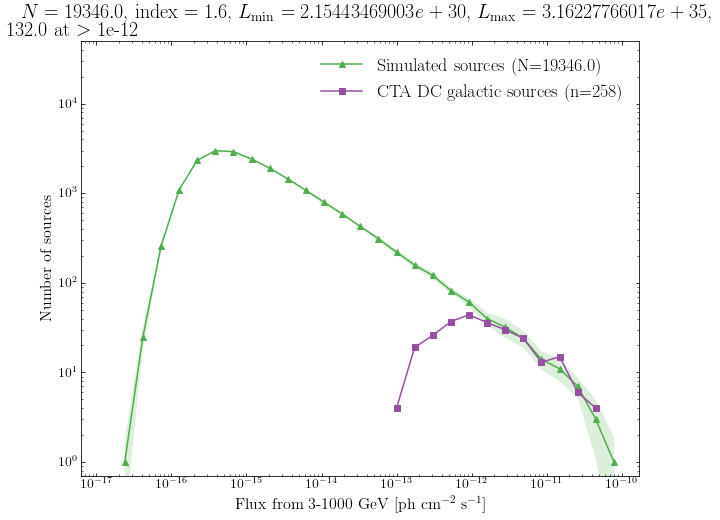

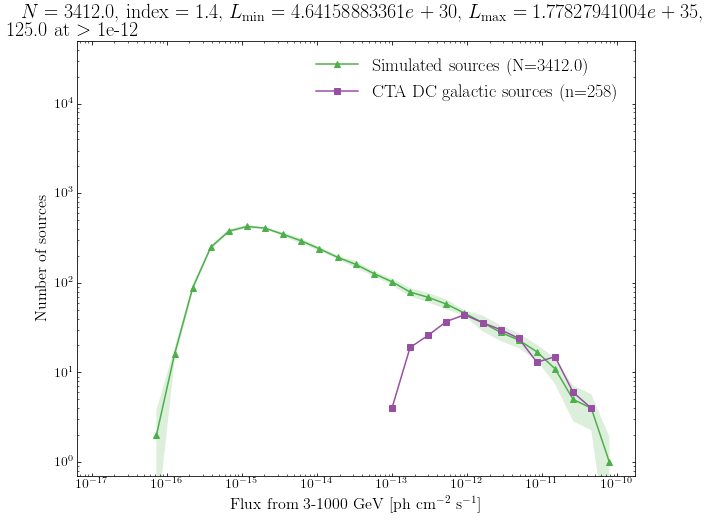

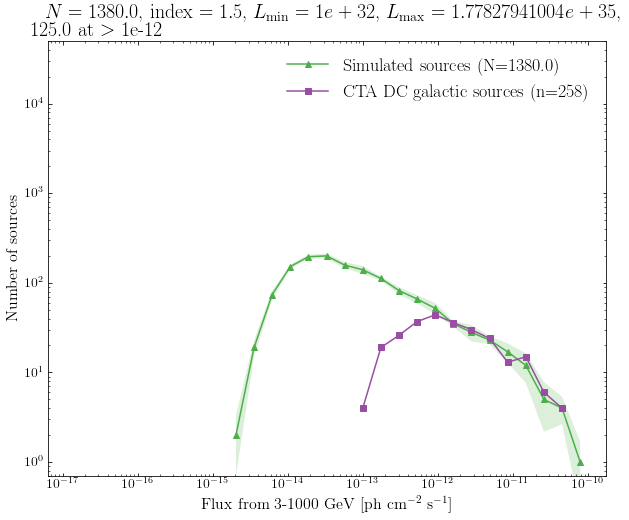

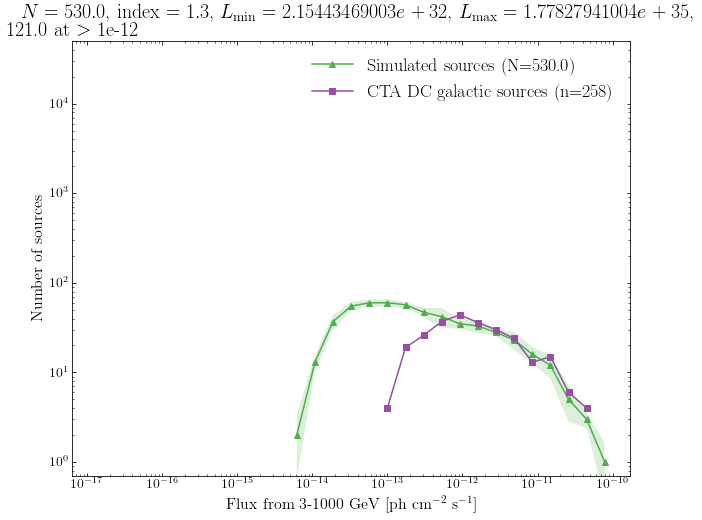

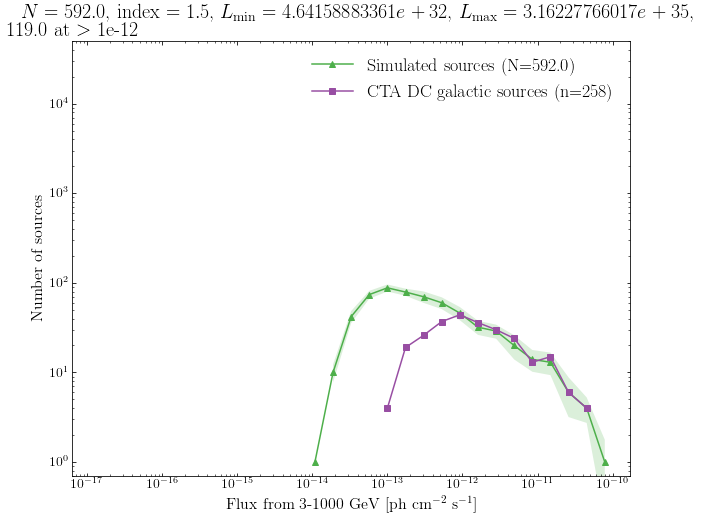

In [40]:
###Only SNR/spp/pwn population
### Do several mock galaxies with different luminosity function/no. sources

###These options showed to reproduce the number of sources at high flux

frac_op = []
std_frac_op = []
lb_frac_TeV = []
lb_frac_TeV_std = []

L_min = [1e31,5e31,1e32]
aa = [1.2,1.5,1.8,2.1]
L_max = [2e35]


L_min = np.logspace(30,33,10)
L_max = np.logspace(34,36,10)
#L_min = [1e31]
aa = [1.3,1.4,1.5,1.6,1.7]
L_min = np.logspace(30,33,10)
# L_min = [1e31,2e31,3e31,4e31,5e31,6e31,7e31,8e31,9e31,1e32]
#aa = [1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
L_max = np.logspace(35,36,5)
# L_max = [1.77e35]

# print L_max



options = []
Nft = 137
ft = 1e-12

Nft = np.sum(hist_CTA[bins_mean>ft])

Dmin = 8*kpc
list_chi2 = []
for Lmin in L_min:
    for a in aa:
        for Lmax in L_max:
            N = Nft*(Lmin**(1-a)-Lmax**(1-a))/((4*np.pi*ft*Dmin**2)**(1-a)-Lmax**(1-a))
#             print N
            N = np.rint(N)
            if N > 100000:
                print a,Lmin,Lmax
                print "Too much sources :("
                lb_frac_TeV.append(np.inf*np.zeros(len(lb)))
                continue
                
            
            lb_frac,std_lb_frac,mp,lb_tev,lb_tev_std,hist,std_hist = ave_samples(10,Nsnr=N,LF_i_snr=a,
                            Lmin_snr=Lmin,Lmax_snr=Lmax,alpha=alp,beta=bet,H=H,
                           ft=ft,spectrum=spec_ave_CTA,cm=False)
            chi2 =  lnlike(hist_CTA[bins_mean>ft], hist[bins_mean>ft])
            counts_sim = np.sum(hist[bins_mean>ft])
            counts_norm = np.sum(hist_CTA[bins_mean>ft])
            print 'CTA no. sources at flux > %s: %s'%(ft,counts_norm)
            print 'Simulation no. sources at flux > %s: %s'%(ft,counts_sim)
            print '-2lnL = %s'%chi2
            if chi2 < 5:
                options.append((N,a,Lmin,Lmax))
                print "::::::Plotting histogram::::::"
                plot_hist_func(bins_mean,hist,std_hist,hist_CTA,(N,a,Lmin,Lmax),ft)
                list_chi2.append(chi2)
                frac_op.append(lb_frac)
                std_frac_op.append(std_lb_frac)
                lb_frac_TeV.append(lb_tev)
                lb_frac_TeV_std.append(lb_tev_std)
            
print min(list_chi2),options[np.argmin(list_chi2)]

Doing 10 sample galaxys with 3700 sources,LF_i = 1.3, Lmin = 1e+30,Lmax=2e+35, 
        this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 149.0
-2lnL = 11.3903426208
::::::Plotting histogram::::::
Doing 10 sample galaxys with 15500 sources,LF_i = 1.5, Lmin = 1e+30,Lmax=2e+35, 
        this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 141.0
-2lnL = 8.21224329888
::::::Plotting histogram::::::
Doing 10 sample galaxys with 68500 sources,LF_i = 1.7, Lmin = 1e+30,Lmax=2e+35, 
        this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 126.0
-2lnL = 12.7425767376
::::::Plotting histogram::::::
Doing 10 sample galaxys with 1800 sources,LF_i = 1.3, Lmin = 1e+31,Lmax=2e+35, 
        this might take some time...
...done
CTA no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 146.0
-2lnL =

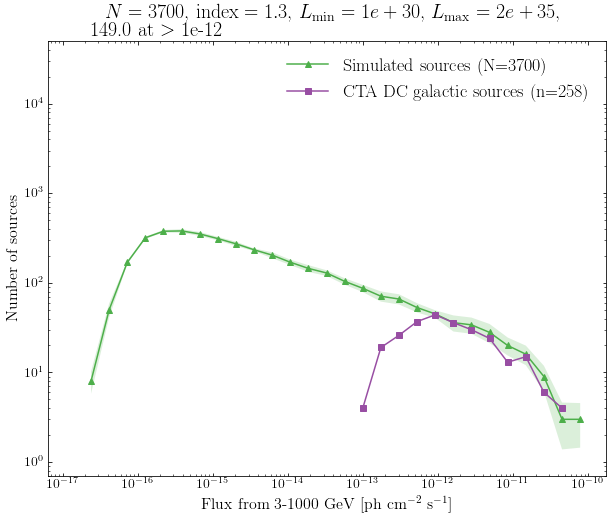

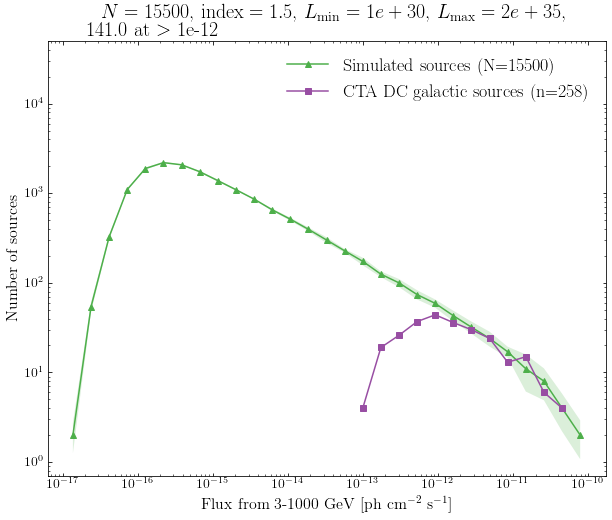

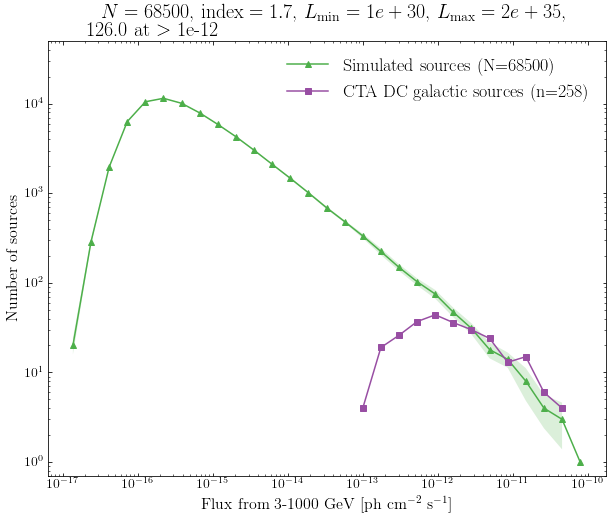

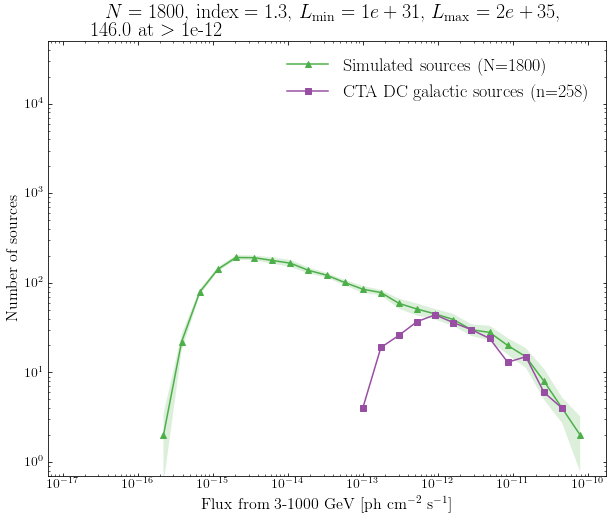

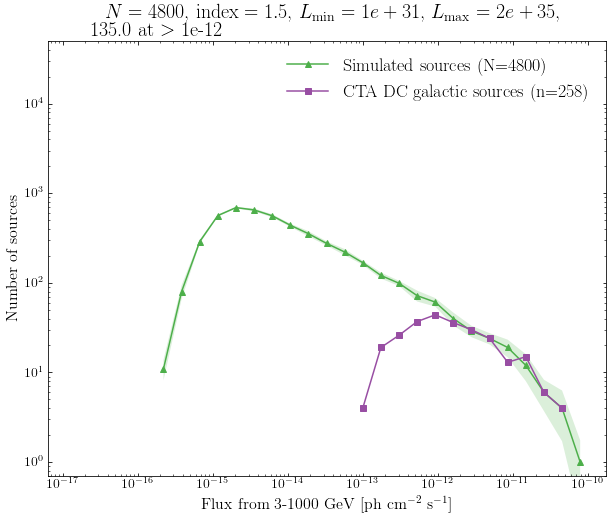

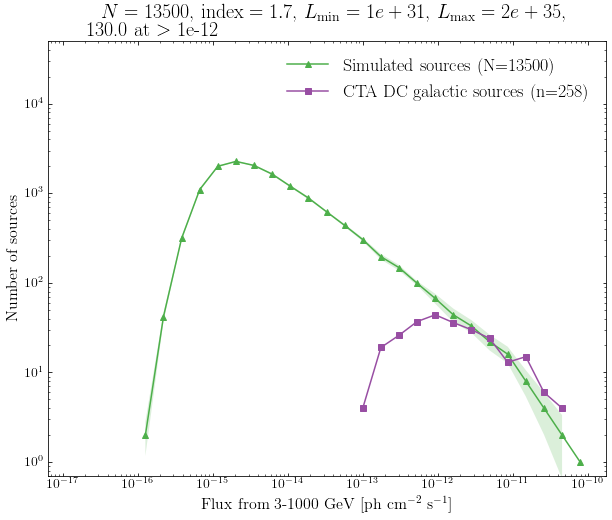

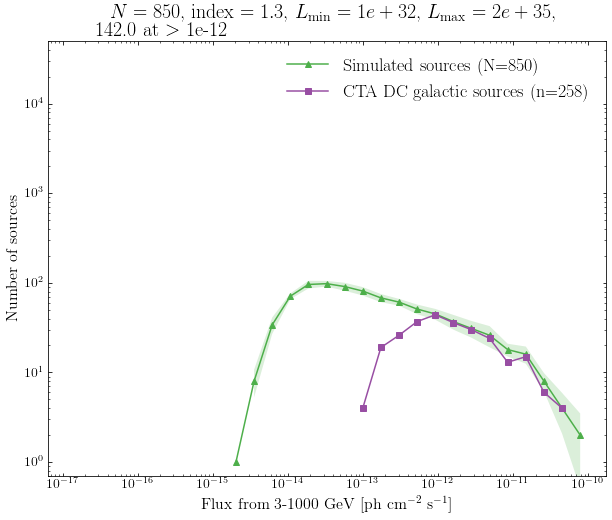

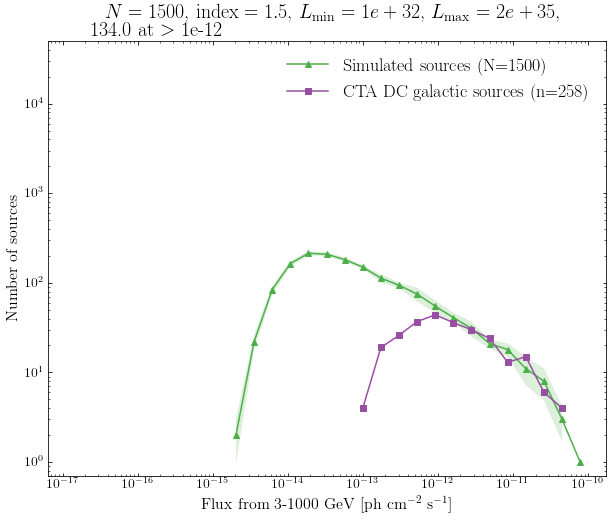

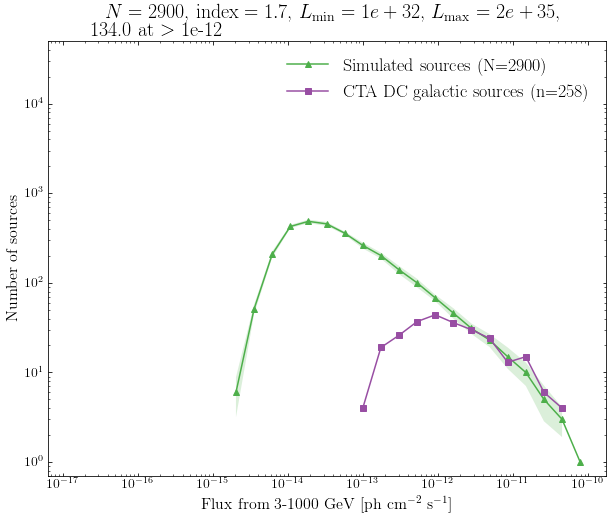

In [72]:
###Only SNR/spp/pwn population
### Do several mock galaxies with different luminosity function/no. sources

###These options showed to reproduce the number of sources at high flux

frac_op = []
std_frac_op = []
lb_frac_TeV = []
lb_frac_TeV_std = []



# options = [(1900,1.2,1e30),(3700,1.3,1e30),(7300,1.4,1e30),(15500,1.5,1e30),(33000,1.6,1e30),
#           (68000,1.7,1e30),(1200,1.2,1e31),(3000,1.4,1e31),(2800,1.4,1e31),(4800,1.5,1e31),
#           (8400,1.6,1e31),(13500,1.7,1e31),(620,1.2,1e32),(850,1.3,1e32),(1100,1.4,1e32),(1500,1.5,1e32),
#           (2100,1.6,1e32),(2900,1.7,1e32)]

options = [(3700,1.3,1e30),(15500,1.5,1e30),(68500,1.7,1e30),(1800,1.3,1e31),(4800,1.5,1e31),
          (13500,1.7,1e31),(850,1.3,1e32),(1500,1.5,1e32),(2900,1.7,1e32)]

Lmax = 2e35
for op in options:
    N,a,Lmin = op

    lb_frac,std_lb_frac,mp,lb_tev,lb_tev_std,hist,std_hist = ave_samples(10,Nsnr=N,LF_i_snr=a,
                    Lmin_snr=Lmin,Lmax_snr=Lmax,
                   alpha=alp,beta=bet,H=H,
                   ft=ft,spectrum=spec_ave_CTA,cm=False)
    chi2 =  lnlike(hist_CTA[bins_mean>ft], hist[bins_mean>ft])
    counts_sim = np.sum(hist[bins_mean>ft])
    counts_norm = np.sum(hist_CTA[bins_mean>ft])
    print 'CTA no. sources at flux > %s: %s'%(ft,counts_norm)
    print 'Simulation no. sources at flux > %s: %s'%(ft,counts_sim)
    print '-2lnL = %s'%chi2
    if chi2 < 50:
        print "::::::Plotting histogram::::::"
        plot_hist_func(bins_mean,hist,std_hist,hist_CTA,(N,a,Lmin,Lmax),ft)
        list_chi2.append(chi2)
        frac_op.append(lb_frac)
        std_frac_op.append(std_lb_frac)
        lb_frac_TeV.append(lb_tev)
        lb_frac_TeV_std.append(lb_tev_std)


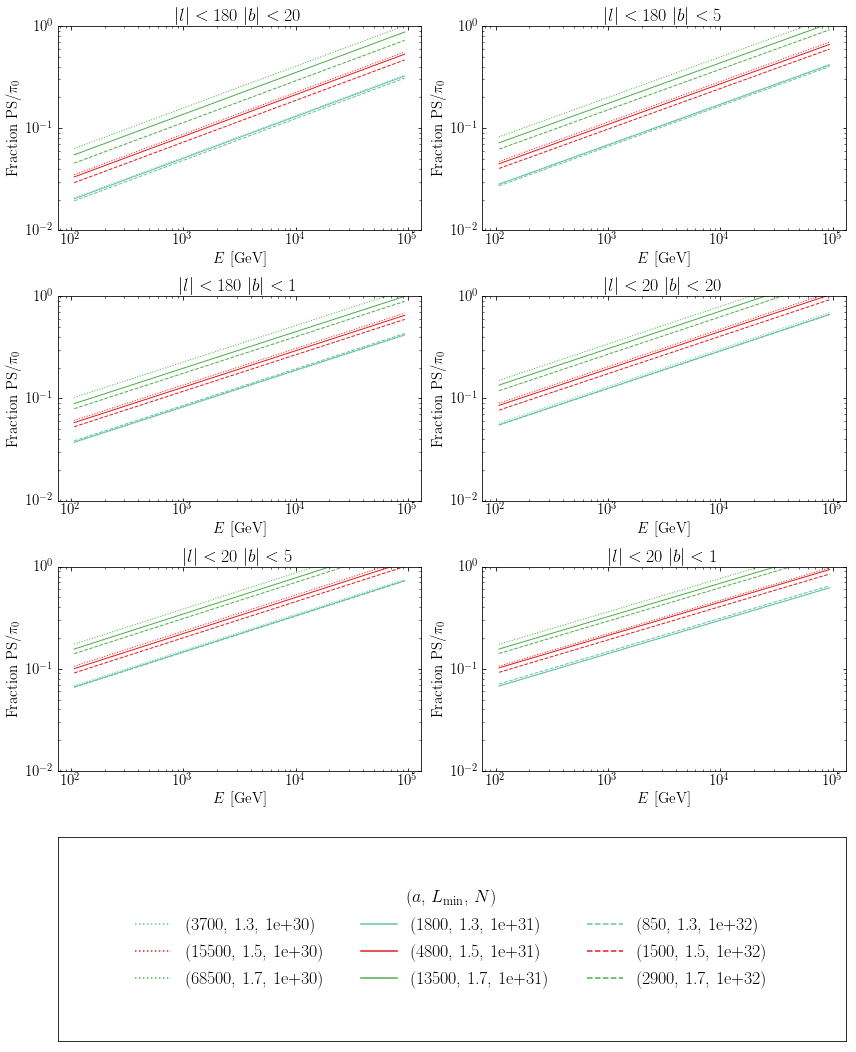

In [73]:
###Plot the fraction of unresolved/diffuse at different l,b
frac_op = np.array(frac_op)
std_frac_op = np.array(std_frac_op)

fig = plt.figure(figsize=(12,16))
gs = gridspec.GridSpec(4,2)

for di in range(len(lb)):
    #print "At abs(l,b):",lb[di]
    gsi = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs[di])
    ax = plt.Subplot(fig,gs[di]) 
    for i,sf in enumerate(frac_op[:,di]):
        if options[i][1]==1.3:
            #_ls = '-'
            color = colors[0]
        elif options[i][1]==1.5:
            #_ls = '--'
            color = colors[5]
        elif options[i][1]==1.7:
            #_ls = '-.'
            color = colors[2]
        else:
             color= ax._get_lines.prop_cycler.next()['color']
            
        if options[i][2]==1e30:
            #color = colors[5] #red
            _ls = ':'
        elif options[i][2]==1e31:
            #color = colors[0] #blue
            _ls = '-'
        elif options[i][2]== 1e32:
            #color= colors[2] #green
            _ls = '--'
        else:
            _ls = "-"
        if options[i][1]==1.8 and options[i][2]==2e34:
            thick = 2
        else:
            thick = 1
        #print options_print[i]
        div = frac_op[i,di]
        ax.loglog(E,div,label=options[i],ls=_ls,color=color,lw=thick)#marker=_ms,ms=1)
        
        #ax.fill_between(E,div-std_frac_op[i,di],div+std_frac_op[i,di],alpha=0.2)#,facecolor=colors[i])
        ax.set_xscale('log',nonposx='clip')
        ax.set_yscale('log',nonposy='clip')
        #print "At %.1f GeV the fraction is %.2f "%(E[iE100],div[iE100])
#     ax.fill_between(E,frac_op[2,di],frac_op[4,di],alpha=0.2,facecolor=colors[2])
#     ax.fill_between(E,frac_op[6,di],frac_op[4,di],alpha=0.2,facecolor=colors[0])
    ax.set_ylim([0.01,1])
    ax.set_title(r'$|l| < %s \ |b| < %s$'%lb[di],fontsize=18)
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=15)
    ax.set_xlabel(r"$E$ [GeV]",fontsize=15)
    ax.set_ylabel(r'Fraction $\rm PS/ \pi_0$',fontsize=15)
    fig.add_subplot(ax)
    #plt.legend(loc=2,frameon=False,fontsize=15,ncol=2)#, title=options_labels[0:4])
##Plot legend in seperate subplot
plt.gca().set_prop_cycle(None)
gsi = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=gs[di+1])

ax = plt.subplot(gs[-1,:]) 

ax.set_frame_on(True)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for i,sf in enumerate(frac_op[:,di]):      
    div = frac_op[i,di]
    if options[i][1]==1.3:
        #_ls = '-'
        color = colors[0]
    elif options[i][1]==1.5:
        #_ls = '--'
        color = colors[5]
    elif options[i][1]==1.7:
        #_ls = '-.'
        color = colors[2]
#     else:
#         color= ax._get_lines.prop_cycler.next()['color']

    if options[i][2]==1e30:
        #color = colors[5] #red
        _ls = ':'
    elif options[i][2]==1e31:
        #color = colors[0] #blue
        _ls = '-'
    elif options[i][2]== 1e32:
        #color= colors[2] #green
        _ls = '--'
    else:
        _ls = "-"
    if options[i][0]==1.8 and options[i][1]==2e34:
        thick = 2
    else:
        thick = 1
    ax.plot(0,0,label=options[i],ls=_ls,color=color)
    
fig.add_subplot(ax)
lg = plt.legend(loc=10,title=r'($N$, $a$,$L_{\rm min}$)',frameon=False,ncol=3,fontsize=18)
lg.get_title().set_fontsize(18)
#fig2.suptitle(r'PS index = %s, diffuse index = 2.52-2.61'%(snr_index),fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('fraction_ps_diffuse.pdf')

## Flux at 1 TeV

In [74]:
lb_frac_TeV = np.array(lb_frac_TeV)
lb_frac_TeV_std = np.array(lb_frac_TeV_std)
x = np.array(aa) #L_min

y = L_min
X,Y = np.meshgrid(x,y)

lb_frac_TeV_0 = lb_frac_TeV[:,0]
Z = lb_frac_TeV_0.reshape(X.shape,order='C')
#X = np.log10(X)
Y = np.log10(Y)

ValueError: cannot reshape array of size 9 into shape (10,5)

In [ ]:
from matplotlib.colors import LogNorm

Z = np.ma.masked_where(np.isnan(Z), Z)
cmap = plt.cm.viridis
cmap.set_bad('white')
plt.pcolor(X,Y,Z,norm=LogNorm(vmin=0.01, vmax=1),cmap=cmap,vmin = 0.01,vmax=1)
plt.xlabel("a")
plt.ylabel("Lmin")
plt.colorbar()